In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## 0. Loading & Processing Data

In [2]:
df = pd.read_csv(r".\NUS_IT\Train_Set.csv")
test_df = pd.read_csv(r".\NUS_IT\Test_Set.csv")
print(df.shape)
df.head()

(2193, 351)


,length_51,length_52,length_53,length_54,length_55,length_56,length_57,length_58,length_59,length_60,...,length_392,length_393,length_394,length_395,length_396,length_397,length_398,length_399,length_400,class_label
0,0.000152,0.000082,0.000087,0.000092,0.000099,0.000125,0.000122,0.000115,0.000151,0.000167,...,0.007396,0.007193,0.006973,0.006481,0.006139,0.005958,0.005578,0.005327,0.005142,healthy
1,0.006256,0.006413,0.006512,0.006469,0.006810,0.007070,0.007748,0.008088,0.008671,0.008835,...,0.017830,0.017033,0.016373,0.015371,0.014340,0.013975,0.013243,0.012725,0.012267,healthy
2,0.003783,0.003886,0.004063,0.004237,0.004481,0.004832,0.004960,0.005605,0.005919,0.006480,...,0.010957,0.010481,0.009782,0.009211,0.008800,0.008320,0.007869,0.007286,0.007020,healthy
3,0.004635,0.004471,0.004383,0.004829,0.004920,0.005056,0.005475,0.006158,0.007174,0.007697,...,0.010032,0.008933,0.008970,0.008546,0.008125,0.007587,0.007501,0.006931,0.006663,healthy
4,0.011315,0.010045,0.009795,0.009906,0.010630,0.011467,0.013024,0.014853,0.016874,0.017501,...,0.009118,0.008535,0.008233,0.007754,0.007584,0.006933,0.006530,0.006378,0.005842,healthy


In [3]:
df.columns[df.isna().sum()>0] # no columns that have 0 values (nice)

Index([], dtype='object')

In [4]:
cols_range=df.describe().loc['max']-df.describe().loc['min']
print(cols_range.min(),cols_range.max()) 
# smallest range in values of a single col is 0.0475, largest range in values of a single value is 0.937 
# --> disparity in ranges is present but nt very concerning + methods like DT & RF to be used >> more robust to diff in magnitudes/ scalars
# shld prob standardize

0.047518527000000005 0.936508562


In [5]:
df.isna().sum()

length_51      0
length_52      0
length_53      0
length_54      0
length_55      0
              ..
length_397     0
length_398     0
length_399     0
length_400     0
class_label    0
Length: 351, dtype: int64

In [6]:
df.dtypes.value_counts() # 350 columns with float dtypes (decimal type); 1 which is non-numeric (last one)

float64    350
object       1
dtype: int64

In [7]:
df['class_label'].value_counts() # mmmmmm, imbalanced dataset; ought to replicate/ SMOTE --> not too concerned w that

early stage cancer        781
screening stage cancer    490
mid stage cancer          453
late stage cancer         409
healthy                    60
Name: class_label, dtype: int64

In [8]:
dic={"healthy":1,"screening stage cancer":1,"early stage cancer":2,"mid stage cancer":3,"late stage cancer":4} 
# presumption is that screening stage is before early stage --> tho by right no true need to have this ranked necessarily + can modify easily
df['class_label'].map(dic).value_counts() # mapped appropriately

2    781
1    550
3    453
4    409
Name: class_label, dtype: int64

In [9]:
df['class_label'] = df['class_label'].map(dic) # changes the class_label column to numeric (ML model requires numeric data)
test_df['class_label'] = test_df['class_label'].map(dic) # likewise for the target

## 1. Splitting and Balancing Data

In [10]:
#### --> train test split first
r_state = 27 # for controlling of state 
target = "class_label"
X_cols=[i for i in df.columns if i!=target]
X_train,X_test,y_train,y_test= train_test_split(df[X_cols],df[target],test_size=0.35,stratify=df['class_label'],random_state = r_state)
df = pd.concat([X_train,y_train],axis=1)
dft = pd.concat([X_test,y_test],axis=1)

In [11]:
X_features = [x for x in df.columns if x!=target]

In [12]:
scaler = StandardScaler()
df[X_features] = scaler.fit_transform(df[X_features])

In [13]:
## will also upsample all instances of healthy class (such that model doesn't neglect that class)
# df = pd.concat([df,df[df['class_label']==0]],axis=0).reset_index().drop(columns=['index']) ## nt much of an impact

<Axes: >

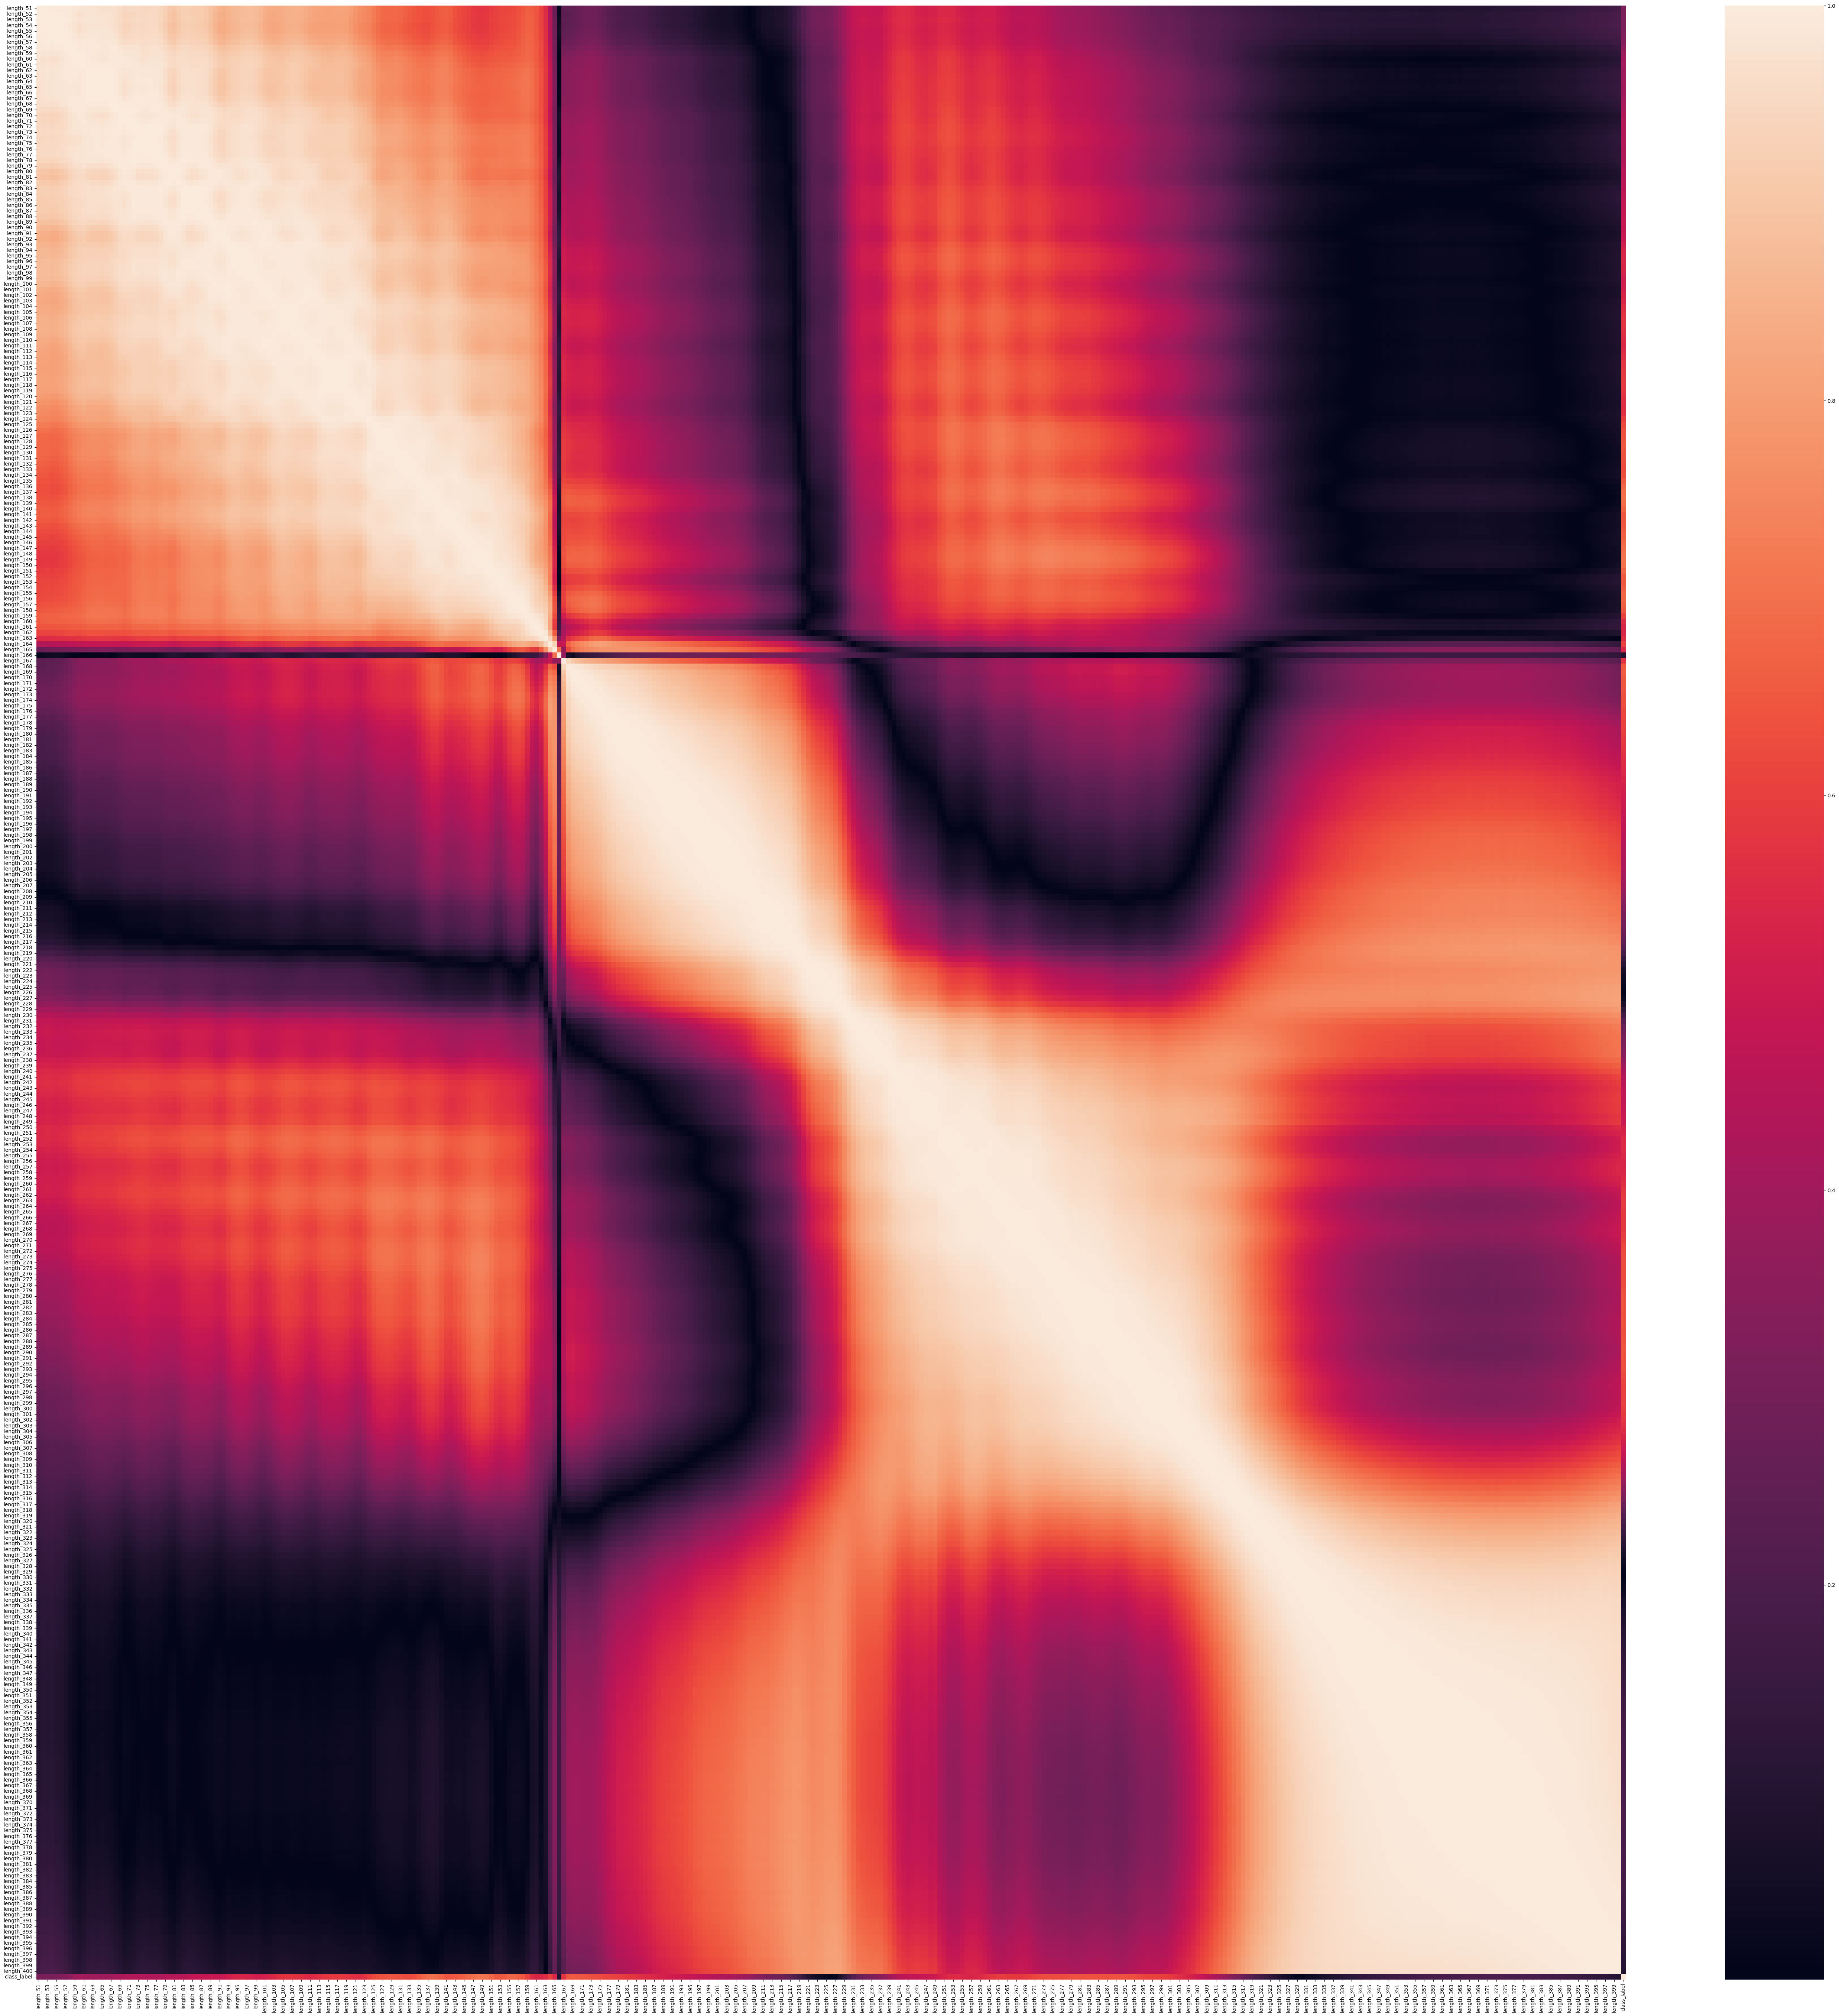

In [14]:
f,ax = plt.subplots(figsize=(69, 69))
sns.heatmap(abs(df.corr()))

## 2. Identifying Important Features (Columns)

In [15]:
model = RandomForestClassifier(random_state=r_state,class_weight='balanced')
model.fit(df[X_cols], df[target])
sig_features = model.feature_importances_
feature_scores = sorted([(i,e) for i,e in enumerate(sig_features)],key=lambda x:x[-1],reverse=True)
forest_features = df.columns[list(map(lambda x:x[0],feature_scores))]

In [16]:
# Also will take a while as model is being trained
def model_trainer(df,dft,best_cols):
    dt_clf  = DecisionTreeClassifier(random_state=r_state,class_weight='balanced')
    dt_clf.fit(df[best_cols],df[target])

    rf_clf  = RandomForestClassifier(random_state=r_state,class_weight='balanced')
    rf_clf.fit(df[best_cols],df[target])

    xgb_clf = GradientBoostingClassifier(random_state=r_state)
    xgb_clf.fit(df[best_cols],df[target])

    dt_pred  = dt_clf.predict(dft[best_cols]) # mb just use weights?

    rf_pred  = rf_clf.predict(dft[best_cols])

    xgb_pred = xgb_clf.predict(dft[best_cols])

    reverse_lis = [k for k,v in sorted(dic.items(),key=lambda x:x[-1])]
    reverse_lis = [reverse_lis[0]+'/'+reverse_lis[1]]+reverse_lis[2:]
    print("Decision Tree Report:")
    print(classification_report(dft[target],dt_pred,target_names = reverse_lis))
    print("Random Forest Report:")
    print(classification_report(dft[target],rf_pred,target_names = reverse_lis))
    print("XGBoost Report:")
    print(classification_report(dft[target],xgb_pred,target_names = reverse_lis))


In [17]:
dft[X_features] = scaler.transform(dft[X_features])

In [18]:
# code cell can run for abt 30 min >> advisable to view results in cell below
'''
for i in [50,75,100,125,150,175,200,225,250,275,300]: 
    print(f"Top {i} features")
    best_cols = forest_features[:i]
    model_trainer(df,dft,best_cols)  
'''

Top 50 features
Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.83      0.81      0.82       193
            early stage cancer       0.80      0.81      0.81       273
              mid stage cancer       0.70      0.75      0.73       159
             late stage cancer       0.89      0.85      0.87       143

                      accuracy                           0.80       768
                     macro avg       0.81      0.80      0.80       768
                  weighted avg       0.81      0.80      0.80       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.87      0.87      0.87       193
            early stage cancer       0.80      0.87      0.83       273
              mid stage cancer       0.75      0.72      0.74       159
             late stage cancer       0.92      0.84      0.88       143


In [ ]:
"""
Top 50 features
Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.83      0.81      0.82       193
            early stage cancer       0.80      0.81      0.81       273
              mid stage cancer       0.70      0.75      0.73       159
             late stage cancer       0.89      0.85      0.87       143

                      accuracy                           0.80       768
                     macro avg       0.81      0.80      0.80       768
                  weighted avg       0.81      0.80      0.80       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.87      0.87      0.87       193
            early stage cancer       0.80      0.87      0.83       273
              mid stage cancer       0.75      0.72      0.74       159
             late stage cancer       0.92      0.84      0.88       143

                      accuracy                           0.83       768
                     macro avg       0.84      0.82      0.83       768
                  weighted avg       0.83      0.83      0.83       768

XGBoost Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.86      0.81      0.84       193
            early stage cancer       0.80      0.87      0.83       273
              mid stage cancer       0.75      0.79      0.77       159
             late stage cancer       0.93      0.80      0.86       143

                      accuracy                           0.82       768
                     macro avg       0.84      0.82      0.82       768
                  weighted avg       0.83      0.82      0.82       768

Top 75 features
Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.82      0.87      0.84       193
            early stage cancer       0.81      0.81      0.81       273
              mid stage cancer       0.74      0.70      0.72       159
             late stage cancer       0.88      0.86      0.87       143

                      accuracy                           0.81       768
                     macro avg       0.81      0.81      0.81       768
                  weighted avg       0.81      0.81      0.81       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.86      0.90      0.88       193
            early stage cancer       0.84      0.85      0.85       273
              mid stage cancer       0.78      0.79      0.79       159
             late stage cancer       0.94      0.86      0.90       143

                      accuracy                           0.85       768
                     macro avg       0.86      0.85      0.85       768
                  weighted avg       0.85      0.85      0.85       768

XGBoost Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.85      0.85      0.85       193
            early stage cancer       0.82      0.86      0.84       273
              mid stage cancer       0.77      0.78      0.77       159
             late stage cancer       0.93      0.82      0.87       143

                      accuracy                           0.83       768
                     macro avg       0.84      0.83      0.83       768
                  weighted avg       0.84      0.83      0.83       768

Top 100 features
Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.81      0.80      0.81       193
            early stage cancer       0.80      0.82      0.81       273
              mid stage cancer       0.79      0.79      0.79       159
             late stage cancer       0.91      0.87      0.89       143

                      accuracy                           0.82       768
                     macro avg       0.83      0.82      0.82       768
                  weighted avg       0.82      0.82      0.82       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.86      0.90      0.88       193
            early stage cancer       0.85      0.86      0.85       273
              mid stage cancer       0.79      0.82      0.80       159
             late stage cancer       0.95      0.85      0.89       143

                      accuracy                           0.86       768
                     macro avg       0.86      0.85      0.86       768
                  weighted avg       0.86      0.86      0.86       768

XGBoost Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.87      0.85      0.86       193
            early stage cancer       0.83      0.87      0.85       273
              mid stage cancer       0.76      0.81      0.78       159
             late stage cancer       0.94      0.81      0.87       143

                      accuracy                           0.84       768
                     macro avg       0.85      0.84      0.84       768
                  weighted avg       0.85      0.84      0.84       768

Top 125 features
Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.80      0.83      0.82       193
            early stage cancer       0.80      0.82      0.81       273
              mid stage cancer       0.78      0.74      0.76       159
             late stage cancer       0.91      0.87      0.89       143

                      accuracy                           0.82       768
                     macro avg       0.82      0.82      0.82       768
                  weighted avg       0.82      0.82      0.82       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.86      0.89      0.87       193
            early stage cancer       0.85      0.86      0.86       273
              mid stage cancer       0.79      0.81      0.80       159
             late stage cancer       0.94      0.85      0.89       143

                      accuracy                           0.85       768
                     macro avg       0.86      0.85      0.85       768
                  weighted avg       0.86      0.85      0.85       768

XGBoost Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.87      0.86      0.86       193
            early stage cancer       0.83      0.86      0.84       273
              mid stage cancer       0.77      0.81      0.79       159
             late stage cancer       0.94      0.83      0.88       143

                      accuracy                           0.84       768
                     macro avg       0.85      0.84      0.84       768
                  weighted avg       0.85      0.84      0.84       768

Top 150 features
Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.80      0.84      0.82       193
            early stage cancer       0.80      0.79      0.80       273
              mid stage cancer       0.72      0.73      0.73       159
             late stage cancer       0.91      0.84      0.87       143

                      accuracy                           0.80       768
                     macro avg       0.81      0.80      0.80       768
                  weighted avg       0.80      0.80      0.80       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.87      0.90      0.89       193
            early stage cancer       0.86      0.87      0.86       273
              mid stage cancer       0.81      0.81      0.81       159
             late stage cancer       0.94      0.87      0.90       143

                      accuracy                           0.86       768
                     macro avg       0.87      0.86      0.86       768
                  weighted avg       0.86      0.86      0.86       768

XGBoost Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.89      0.88      0.88       193
            early stage cancer       0.84      0.88      0.86       273
              mid stage cancer       0.77      0.80      0.78       159
             late stage cancer       0.94      0.82      0.87       143

                      accuracy                           0.85       768
                     macro avg       0.86      0.84      0.85       768
                  weighted avg       0.85      0.85      0.85       768

Top 175 features
Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.82      0.85      0.84       193
            early stage cancer       0.81      0.83      0.82       273
              mid stage cancer       0.74      0.73      0.74       159
             late stage cancer       0.89      0.83      0.86       143

                      accuracy                           0.82       768
                     macro avg       0.82      0.81      0.81       768
                  weighted avg       0.82      0.82      0.82       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.88      0.91      0.89       193
            early stage cancer       0.85      0.88      0.86       273
              mid stage cancer       0.81      0.79      0.80       159
             late stage cancer       0.94      0.87      0.91       143

                      accuracy                           0.87       768
                     macro avg       0.87      0.86      0.87       768
                  weighted avg       0.87      0.87      0.87       768

XGBoost Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.88      0.88      0.88       193
            early stage cancer       0.83      0.89      0.86       273
              mid stage cancer       0.78      0.79      0.78       159
             late stage cancer       0.94      0.82      0.88       143

                      accuracy                           0.85       768
                     macro avg       0.86      0.84      0.85       768
                  weighted avg       0.85      0.85      0.85       768

Top 200 features
Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.82      0.84      0.83       193
            early stage cancer       0.82      0.85      0.83       273
              mid stage cancer       0.78      0.70      0.74       159
             late stage cancer       0.86      0.86      0.86       143

                      accuracy                           0.82       768
                     macro avg       0.82      0.81      0.82       768
                  weighted avg       0.82      0.82      0.82       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.87      0.90      0.89       193
            early stage cancer       0.85      0.87      0.86       273
              mid stage cancer       0.81      0.80      0.80       159
             late stage cancer       0.94      0.86      0.90       143

                      accuracy                           0.86       768
                     macro avg       0.87      0.86      0.86       768
                  weighted avg       0.86      0.86      0.86       768

XGBoost Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.88      0.87      0.87       193
            early stage cancer       0.82      0.88      0.85       273
              mid stage cancer       0.78      0.78      0.78       159
             late stage cancer       0.94      0.84      0.89       143

                      accuracy                           0.85       768
                     macro avg       0.86      0.84      0.85       768
                  weighted avg       0.85      0.85      0.85       768

Top 225 features
Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.82      0.82      0.82       193
            early stage cancer       0.81      0.86      0.83       273
              mid stage cancer       0.80      0.73      0.76       159
             late stage cancer       0.89      0.88      0.88       143

                      accuracy                           0.83       768
                     macro avg       0.83      0.82      0.83       768
                  weighted avg       0.83      0.83      0.83       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.87      0.91      0.89       193
            early stage cancer       0.87      0.87      0.87       273
              mid stage cancer       0.82      0.82      0.82       159
             late stage cancer       0.94      0.87      0.90       143

                      accuracy                           0.87       768
                     macro avg       0.87      0.87      0.87       768
                  weighted avg       0.87      0.87      0.87       768

XGBoost Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.88      0.87      0.87       193
            early stage cancer       0.83      0.88      0.85       273
              mid stage cancer       0.79      0.79      0.79       159
             late stage cancer       0.94      0.83      0.88       143

                      accuracy                           0.85       768
                     macro avg       0.86      0.84      0.85       768
                  weighted avg       0.85      0.85      0.85       768

Top 250 features
Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.83      0.82      0.82       193
            early stage cancer       0.78      0.84      0.81       273
              mid stage cancer       0.75      0.67      0.71       159
             late stage cancer       0.89      0.87      0.88       143

                      accuracy                           0.81       768
                     macro avg       0.81      0.80      0.81       768
                  weighted avg       0.81      0.81      0.81       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.87      0.90      0.89       193
            early stage cancer       0.87      0.88      0.87       273
              mid stage cancer       0.82      0.82      0.82       159
             late stage cancer       0.94      0.86      0.90       143

                      accuracy                           0.87       768
                     macro avg       0.87      0.87      0.87       768
                  weighted avg       0.87      0.87      0.87       768

XGBoost Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.88      0.86      0.87       193
            early stage cancer       0.82      0.89      0.85       273
              mid stage cancer       0.79      0.78      0.78       159
             late stage cancer       0.94      0.83      0.88       143

                      accuracy                           0.85       768
                     macro avg       0.86      0.84      0.85       768
                  weighted avg       0.85      0.85      0.85       768

Top 275 features
Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.83      0.80      0.82       193
            early stage cancer       0.78      0.86      0.82       273
              mid stage cancer       0.75      0.68      0.71       159
             late stage cancer       0.89      0.87      0.88       143

                      accuracy                           0.81       768
                     macro avg       0.81      0.80      0.81       768
                  weighted avg       0.81      0.81      0.81       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.88      0.91      0.89       193
            early stage cancer       0.87      0.88      0.87       273
              mid stage cancer       0.82      0.82      0.82       159
             late stage cancer       0.94      0.87      0.90       143

                      accuracy                           0.87       768
                     macro avg       0.88      0.87      0.87       768
                  weighted avg       0.87      0.87      0.87       768

XGBoost Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.88      0.85      0.87       193
            early stage cancer       0.82      0.88      0.85       273
              mid stage cancer       0.77      0.78      0.77       159
             late stage cancer       0.94      0.81      0.87       143

                      accuracy                           0.84       768
                     macro avg       0.85      0.83      0.84       768
                  weighted avg       0.84      0.84      0.84       768

Top 300 features
Decision Tree Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.81      0.81      0.81       193
            early stage cancer       0.79      0.84      0.81       273
              mid stage cancer       0.75      0.69      0.72       159
             late stage cancer       0.90      0.89      0.89       143

                      accuracy                           0.81       768
                     macro avg       0.81      0.81      0.81       768
                  weighted avg       0.81      0.81      0.81       768

Random Forest Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.88      0.91      0.89       193
            early stage cancer       0.87      0.88      0.87       273
              mid stage cancer       0.83      0.82      0.83       159
             late stage cancer       0.94      0.87      0.91       143

                      accuracy                           0.88       768
                     macro avg       0.88      0.87      0.87       768
                  weighted avg       0.88      0.88      0.88       768

XGBoost Report:
                                precision    recall  f1-score   support

healthy/screening stage cancer       0.87      0.87      0.87       193
            early stage cancer       0.82      0.89      0.85       273
              mid stage cancer       0.79      0.78      0.78       159
             late stage cancer       0.94      0.83      0.88       143

                      accuracy                           0.85       768
                     macro avg       0.86      0.84      0.85       768
                  weighted avg       0.85      0.85      0.85       768
"""

In [19]:
best_cols = forest_features[:175] # since 175 top ranked features is the lowest number that gives the best performance

In [69]:
# also takes ~ 30 min to run >> best paramters as shown in dictionary assigned to best_gs_params variable below
'''
param_grid = { 
    'n_estimators': [75,100,125], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [2,5, 10, 15], 
    'max_leaf_nodes': [2,3, 6], 
} 

grid_search = GridSearchCV(RandomForestClassifier(random_state=r_state,class_weight='balanced'), 
                           param_grid=param_grid,scoring='f1_weighted') 
grid_search.fit(df[best_cols],df[target])

best_gs_params = (grid_search.best_params_)
'''
best_gs_params = {'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': 6,
 'n_estimators': 125}



"\nparam_grid = { \n    'n_estimators': [75,100,125], \n    'max_features': ['sqrt', 'log2', None], \n    'max_depth': [2,5, 10, 15], \n    'max_leaf_nodes': [2,3, 6], \n} \n\ngrid_search = GridSearchCV(RandomForestClassifier(random_state=r_state), \n                           param_grid=param_grid,scoring='f1_weighted') \ngrid_search.fit(df[best_cols],df[target])\n\nbest_gs_params = (grid_search.best_params_)\n"

In [21]:
reverse_lis = [k for k,v in sorted(dic.items(),key=lambda x:x[-1])]
reverse_lis = [reverse_lis[0]+'/'+reverse_lis[1]]+reverse_lis[2:]


In [22]:
rf = RandomForestClassifier(random_state=r_state,max_depth = 5,max_features='sqrt',max_leaf_nodes=6,n_estimators=125,class_weight='balanced')
rf.fit(df[best_cols],df[target]) 
y_pred = rf.predict(dft[best_cols])
print(classification_report(dft[target],y_pred,target_names = reverse_lis)) 
# hyperparameter model performs comparably well overall to original model >> better f1 performance for healthy/screening stage 
# >> but underperfroms on test set


                                precision    recall  f1-score   support

healthy/screening stage cancer       0.70      0.73      0.72       193
            early stage cancer       0.68      0.65      0.67       273
              mid stage cancer       0.60      0.63      0.62       159
             late stage cancer       0.84      0.82      0.83       143

                      accuracy                           0.70       768
                     macro avg       0.71      0.71      0.71       768
                  weighted avg       0.70      0.70      0.70       768



In [23]:
test_df[X_features] = scaler.transform(test_df[X_features])

In [24]:
print(classification_report(test_df[target],rf.predict(test_df[best_cols]),target_names = reverse_lis))
# hyperparametised model performs worse on test set than model with no change to parameters >> 
# Likely overfitting : https://towardsdatascience.com/4-effective-ways-to-prevent-overfitting-and-why-they-work-f6e3b98aefda

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.65      0.51      0.57       271
            early stage cancer       0.56      0.58      0.57       368
              mid stage cancer       0.53      0.67      0.59       206
             late stage cancer       0.88      0.81      0.84       189

                      accuracy                           0.62      1034
                     macro avg       0.65      0.64      0.64      1034
                  weighted avg       0.63      0.62      0.62      1034



In [26]:
model_clf = RandomForestClassifier(random_state=r_state,class_weight='balanced') # initial model with no change to parameters
model_clf.fit(df[best_cols],df[target])
model_pred = model_clf.predict(test_df[best_cols])
print(classification_report(test_df[target],model_pred,target_names = reverse_lis))

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.75      0.59      0.66       271
            early stage cancer       0.64      0.72      0.68       368
              mid stage cancer       0.63      0.74      0.68       206
             late stage cancer       0.89      0.78      0.83       189

                      accuracy                           0.70      1034
                     macro avg       0.73      0.71      0.71      1034
                  weighted avg       0.71      0.70      0.70      1034



In [27]:
dff = pd.concat([df,dft]) # using entire training dataset

In [28]:
dff[X_features] = scaler.fit_transform(dff[X_features])
test_df[X_features] = scaler.transform(test_df[X_features])

In [29]:
rf_clf = RandomForestClassifier(random_state=r_state,class_weight='balanced')
rf_clf.fit(dff[best_cols],dff[target])
p = rf_clf.predict(test_df[best_cols])

In [30]:
print(classification_report(test_df[target],p,target_names = reverse_lis)) # test is slightly worse, but not a significant drop
# much better than hyperparameterised model

                                precision    recall  f1-score   support

healthy/screening stage cancer       0.76      0.58      0.66       271
            early stage cancer       0.66      0.70      0.68       368
              mid stage cancer       0.60      0.74      0.66       206
             late stage cancer       0.84      0.79      0.82       189

                      accuracy                           0.70      1034
                     macro avg       0.71      0.70      0.70      1034
                  weighted avg       0.71      0.70      0.70      1034

